In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from nbdev import *
%nbdev_default_export data_realsr

Cells will be exported to srthesis.data_realsr,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Config



In [ ]:
%nbdev_export_internal
from fastai.vision import *
from PIL import Image as PILImage
import multiprocessing

In [ ]:
%nbdev_export_internal
path_dataset = Path('datasets/RealSR')

# Generating test patches

In [ ]:
import os
path_canon = path_dataset/"Canon"/"Valid"/"2"
path_nikon = path_dataset/"Nikon"/"Valid"/"2"
fnames = [path_canon/f for f in os.listdir(path_canon) if 'LR2' in f]
fnames += [path_nikon/f for f in os.listdir(path_nikon) if 'LR2' in f]

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
img_fname = ""

@interact
def image_preview(fname = fnames):
    global img_fname
    img_fname = fname

    img = PILImage.open(fname)
    print(str(fname))
    return img.resize((200,200))

interactive(children=(Dropdown(description='fname', options=(PosixPath('datasets/RealSR/Canon/Valid/2/Canon_01…

In [ ]:
tg_sz = 128
img = PILImage.open(img_fname)
size = list(img.size)
@interact
def image_crop(x = (0, size[0], 10), y = (0, size[1], 10)):

    print(f"(Path({str(img_fname)}), {(x,y)}), \\")
    return img.crop((x,y,x+tg_sz,y+tg_sz))

interactive(children=(IntSlider(value=800, description='x', max=1600, step=10), IntSlider(value=950, descripti…

In [ ]:
%nbdev_export_internal
selected_patches = [ \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_003_LR2.png'), (1200, 1050)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_010_LR2.png'), (1320, 790)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_015_LR2.png'), (750, 780)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_006_LR2.png'), (680, 540)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_006_LR2.png'), (660, 1160)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_010_LR2.png'), (1020, 1050)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_012_LR2.png'), (540, 700)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_014_LR2.png'), (1200, 700)), \
           ]

In [ ]:
%nbdev_export

test_patches = [path_dataset/ "Test" / Path(fn).name for fn, _ in selected_patches]

In [ ]:
p = path_dataset/"Test"

def _generate_test_set():
    for fname, crop_pos in test_set:

        print(fname)
        fname_lr = fname
        fname_hr = fname.replace('LR2','HR')

        print(fname, fname_lr, fname_hr)
        
        img_hr = PILImage.open(fname_hr)
        img_lr = PILImage.open(fname_lr)
        x,y = crop_pos
        patch_hr = img_hr.crop((x,y,x+tg_sz,y+tg_sz))
        patch_lr = img_lr.crop((x,y,x+tg_sz,y+tg_sz))
        fpath_hr = p / Path(fname).name
        fpath_lr = p / Path(fname_lr).name
        patch_hr.save(fpath_hr)
        patch_lr.save(fpath_lr)

if not p.exists(): 
    p.mkdir(parents=True, exist_ok=True)
    _generate_test_set()

In [ ]:
class DeterministicCrop:
   
    def __init__(self, dataset_len = 1):
        self.pcts = [(np.random.rand(), np.random.rand()) for i in range(dataset_len * 2)]
        self.__name__ = '_DeterministicCrop'
        self.__annotations__ = {}
        self.curr_idx = 0
        self.dataset_len = dataset_len
    
    def __call__(self, x, size)->Image:
        row_pct, col_pct = self.pcts[self.curr_idx // 2]
        self.curr_idx = (self.curr_idx + 1) % (self.dataset_len)
        rows,cols = tis2hw(size)
        print(row_pct, col_pct)
        row = int((x.size(1)-rows+1) * row_pct)
        col = int((x.size(2)-cols+1) * col_pct)
        return x[:, row:row+rows, col:col+cols].contiguous()

In [ ]:
det_crop = TfmPixel(DeterministicCrop(dataset_len=5))(size=(200, 200))

In [ ]:
#generate valid ds
p = path_dataset/"Valid"
if not p.exists(): 
    p.mkdir(parents=True, exist_ok=True)

    src = _get_src(1.0, 43, 'LR2', det_valid=False)

    ll = src.label_from_func(lambda fname: str(fname).replace('LR2','HR'))

    patches_per_img = 5
    dataset_len = len(ll.valid)*patches_per_img
    valid_crop = TfmPixel(DeterministicCrop(dataset_len=dataset_len))(size=(128, 128))
    
    for idx, (x, y) in enumerate(ll.valid):
        for i in range(patches_per_img):
            fpath_lr = p / f"img{idx}_p{i}_LR2.jpg"
            fpath_hr = p / f"img{idx}_p{i}_HR.jpg"

            x.clone().apply_tfms(valid_crop).save(fpath_lr)
            y.clone().apply_tfms(valid_crop).save(fpath_hr)

0.8252896926477541 0.08979312958956698
0.8252896926477541 0.08979312958956698
0.0942357871874131 0.6664565752021905
0.0942357871874131 0.6664565752021905
0.34074759738278637 0.3948401047540122
0.34074759738278637 0.3948401047540122
0.9606895541739843 0.15555171685103886
0.9606895541739843 0.15555171685103886
0.854198917959964 0.839552742068119
0.854198917959964 0.839552742068119
0.6321756576389921 0.026800616411528977
0.6321756576389921 0.026800616411528977
0.30204160182406514 0.31540168891017195
0.30204160182406514 0.31540168891017195
0.40815092204538306 0.24052708699894643
0.40815092204538306 0.24052708699894643
0.9567644446533119 0.9086036430620262
0.9567644446533119 0.9086036430620262
0.41052930419369027 0.19572894055285706
0.41052930419369027 0.19572894055285706
0.219739433333058 0.55950214393074
0.219739433333058 0.55950214393074
0.20446586905302078 0.7625778077508331
0.20446586905302078 0.7625778077508331
0.250978343736747 0.09776876367684462
0.250978343736747 0.0977687636768446

# Dataset

In [ ]:
%nbdev_export

class CachedImageList(ImageImageList):
    _map = {}
    
    def open(self, i):        
        item = self._map.get(str(i))
        if isinstance(item, Image):
            return item
        item = super().open(i)
        self._map[str(i)] = item
        
        return item
    
class CachedImageImageList(CachedImageList):
    _label_cls = CachedImageList    

In [ ]:
%nbdev_export_internal

def _repeat_il(il:ImageList, times:int=2)->ImageList:
    il_orig = il.new(il.items)
    for i in range(times - 1):
        il.add(il_orig)
    return il

def _get_il(input_type:str='LR2', det_valid = True):
    
    il_canon = CachedImageImageList.from_folder(path_dataset / 'Canon') \
               .filter_by_func(lambda fname: '/2/' in str(fname)) \
               .filter_by_func(lambda fname: input_type in str(fname))

    il_nikon = CachedImageImageList.from_folder(path_dataset / 'Nikon') \
                       .filter_by_func(lambda fname: '/2/' in str(fname)) \
                       .filter_by_func(lambda fname: input_type in str(fname))

    il_canon.add(il_nikon)
    il = il_canon
    
    if det_valid:
        il = il.filter_by_func(lambda fname: 'Valid' not in str(fname))
        il_valid = CachedImageImageList.from_folder(path_dataset / 'Valid') \
                        .filter_by_func(lambda fname: input_type in str(fname))
        il.add(il_valid)
    
    return il

def _get_src(keep_pct: float = 1.0, 
             random_seed: int = 42,
             input_type:str='LR2',
             repeat_train:int = 1,
             repeat_valid:int = 1,
             max_train_len: int = sys.maxsize,
             det_valid=True):
    
    il = _get_il(input_type=input_type,det_valid=det_valid)
   
    if keep_pct < 1.0:
         il = il.use_partial_data(sample_pct=keep_pct, seed=random_seed)
    
    src = il.split_by_valid_func(lambda fname: "Valid" in str(fname))
    
    if max_train_len < sys.maxsize:
        if random_seed is not None: np.random.seed(random_seed)
        rand_idx = np.random.permutation(range_of(src.train))
        src.train = src.train[rand_idx[:max_train_len]]
    
    if repeat_train > 1:
        src.train = _repeat_il(src.train, repeat_train)
        
    if repeat_valid > 1:
        src.valid = _repeat_il(src.valid, repeat_valid)
    
    src.path = src.path.parent
    
    return src

def _get_tfms(y_size:int, dihedral_augs:bool=True, valid_len:int=None):
    crop_rand_patches = crop(size=(y_size,y_size),  row_pct=(0,1), col_pct=(0,1))# pct 
    crop_center_patches = crop(size=(y_size,y_size),  row_pct=0.5, col_pct=0.5)# pct 
    
    #TODO brightness and contrast
    #TODO noise
    train_tfms = [crop_rand_patches]
    if dihedral_augs:
        train_tfms += [dihedral_affine()]
    valid_tfms = []
    return [train_tfms, valid_tfms]
    

In [ ]:
%nbdev_export
"""Obtain DataBunch for given target image size and batch size"""
def get_data_realsr(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = 43,       
             input_type:str = 'LR2', 
             output_type:str = 'HR',
             repeat_train = 1,
             repeat_valid = 1,
             max_train_len: int = sys.maxsize,
             dihedral_augs = True,
             stats: tuple = imagenet_stats) -> ImageDataBunch:
    
    src = _get_src(keep_pct, random_seed, input_type, repeat_train, repeat_valid, max_train_len)

    ll = src.label_from_func(lambda fname: str(fname).replace(input_type,output_type))
    
    iters_in_epoch = int(math.ceil(len(src.train) / float(bs)))

    num_workers = min(iters_in_epoch, multiprocessing.cpu_count() // 4)
    
    print(f"Data: Iters in epoch: {iters_in_epoch}, loading threads: {num_workers}")
    
    data = (ll.transform(
                       _get_tfms(y_size, dihedral_augs, len(src.valid)), 
                       size=None, 
                       tfm_y=True)
                   .databunch(bs=bs, num_workers=num_workers)
                   .normalize(imagenet_stats, do_y=True)
            )
    data.c = 3
    return data

In [ ]:
data = get_data_realsr(128, 16, input_type = 'LR2', output_type='HR', repeat_train = 1, max_train_len = 16)
data

Data: Iters in epoch: 1, loading threads: 1


ImageDataBunch;

Train: LabelList (16 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Valid: LabelList (150 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None

Show some example inputs and targets in task

$ {LR}_{128px} -> {HR}_{256px} $

CPU times: user 356 ms, sys: 64.3 ms, total: 421 ms
Wall time: 309 ms


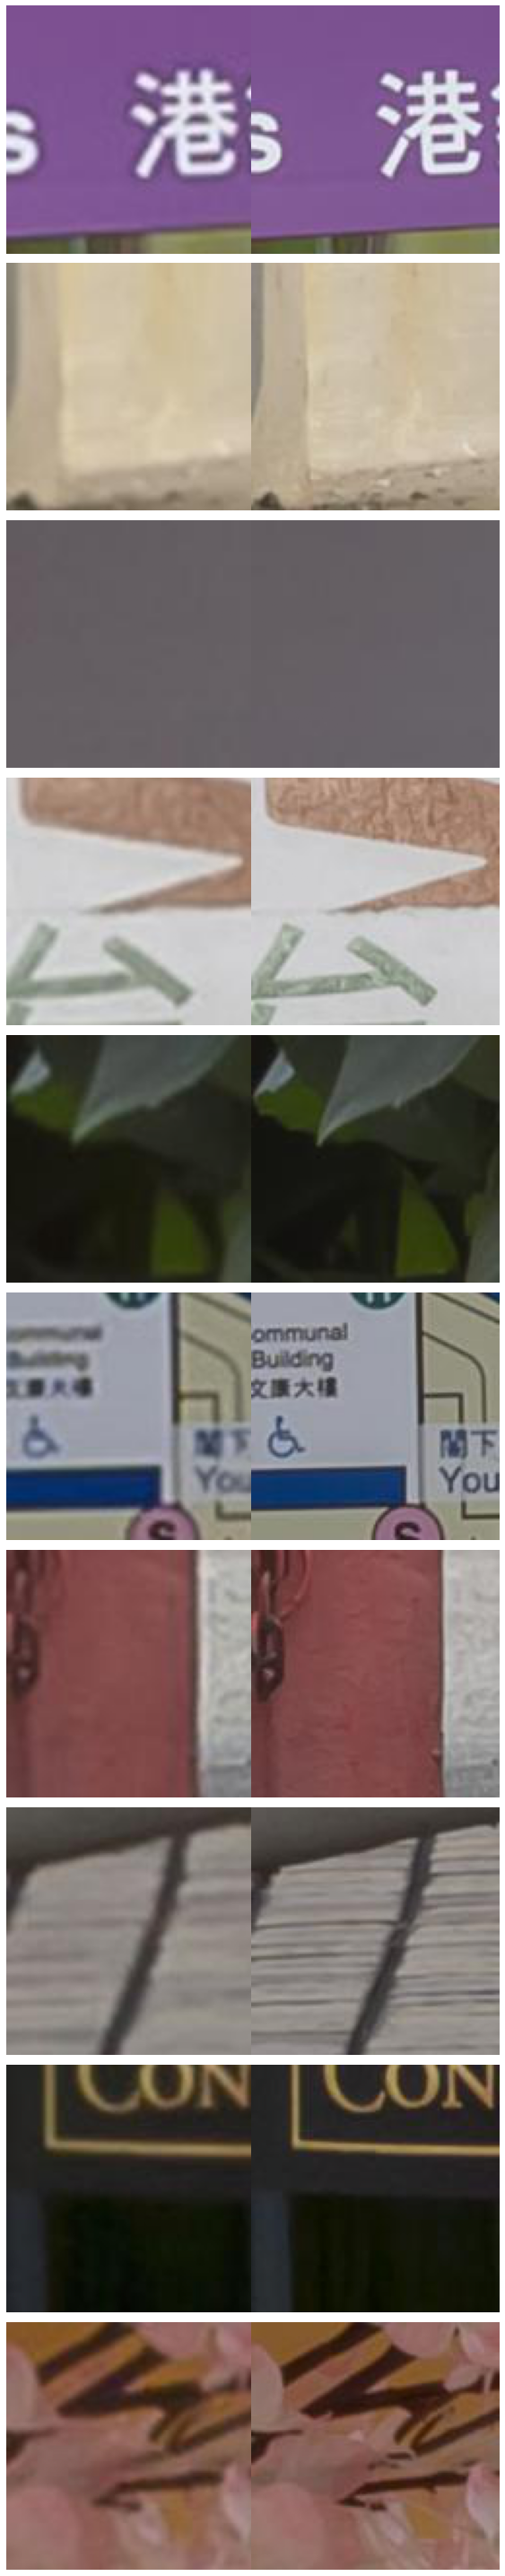

In [ ]:
%%time
data.show_batch(ds_type=DatasetType.Valid, rows=10)

In [ ]:
x = data.valid_ds.x[1].clone()
x.apply_tfms([det_crop])

0.22546489298666783 0.45401587926583487


In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted augmentations.ipynb.
Converted graphs-tests.ipynb.
Converted sr reference.ipynb.
